**DATA GATHERING**

In [ ]:
# Authorization to use drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the dataset from drive

!mkdir dataset
!cp /content/drive/MyDrive/A_Fine_Windy_Day.zip /content/dataset
!unzip /content/dataset/A_Fine_Windy_Day.zip -d /content/dataset

Archive:  /content/dataset/A_Fine_Windy_Day.zip
  inflating: /content/dataset/test_data.csv  
  inflating: /content/dataset/train_data.csv  


**Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import time
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from sklearn.metrics import r2_score

In [ ]:
train = pd.read_csv("/content/dataset/train_data.csv")
test = pd.read_csv("/content/dataset/test_data.csv")

In [ ]:
len(train.columns)

22

**Feature Engineering**

In [ ]:
def create_features(df, fillna=False, label_encoder=True, remove_unimp=True, handle_impossible=False):

  '''
    df : Dataframe;
    fillna : If your model does not support missing values, use this (make it True). 
             I have just added basic fillna with mean, but try different techniques (for example rather than using mean of whole dataset, use mean only of the month the datapoint is in);
    label_encoder : to change categorical variables;
    remove_unimp : Remove unimportant features
    handle_impossible: Replace the impossible values of variables with somewhat believable values
  '''

  # Date related features
  #-----------------------------
  df['datetime'] = df['datetime'].astype('datetime64[ns]')

  df['date'] = df['datetime'].dt.day.astype(str) + '_' + df['datetime'].dt.month.astype(str) + '_' + df['datetime'].dt.year.astype(str)

  df['hour'] = df['datetime'].dt.hour
  df['month'] = df['datetime'].dt.month
  df['day'] = df['datetime'].dt.day

  df['time_frame'] = -1
  df.loc[((7<=df['hour']) & (df['hour']<=19)), 'time_frame'] = 'day'
  df.loc[((7>df['hour']) | (df['hour']>19)), 'time_frame'] = 'night'


  df['Seasons'] = -1

  df.loc[((df['month']<=2) | (df['month']==12)), 'Seasons'] = 'Winter'
  df.loc[((2<df['month']) & (df['month']<=5)), 'Seasons'] = 'Summer'
  df.loc[((5<df['month']) & (df['month']<=9)), 'Seasons'] = 'Monsoon'
  df.loc[((df['month']==10) | (df['month']==11)), 'Seasons'] = 'Post-Monsoon'
  #-----------------------------


  # wind speed related
  #-----------------------------
  df['neg_speed'] = 0
  df.loc[df['wind_speed(m/s)']<0, 'neg_speed'] = 1
  df.loc[df['wind_speed(m/s)']<0, 'wind_speed(m/s)'] = abs(df['wind_speed(m/s)']) 

  df['impossible_speed'] = 0
  df.loc[df['wind_speed(m/s)']>113, 'impossible_speed'] = 1
  df.loc[df['wind_speed(m/s)']>113, 'wind_speed(m/s)'] = df['wind_speed(m/s)'] / 10

  df['rolling_5_mean'] = df['wind_speed(m/s)'].rolling(window=5, min_periods=1).mean().reset_index(level=0,drop=True)
  df['rolling_10_mean'] = df['wind_speed(m/s)'].rolling(window=10, min_periods=1).mean().reset_index(level=0,drop=True)
  df['rolling_20_mean'] = df['wind_speed(m/s)'].rolling(window=20, min_periods=1).mean().reset_index(level=0,drop=True)
  df['rolling_30_mean'] = df['wind_speed(m/s)'].rolling(window=30, min_periods=1).mean().reset_index(level=0,drop=True)

  df['ewm_wind_speed_mean'] = df['wind_speed(m/s)'].ewm(halflife=10).mean().reset_index(level=0,drop=True)

  df['wind_speed_month'] = df.groupby(['month', 'time_frame'])['wind_speed(m/s)'].transform('mean')
  df['wind_speed_hour'] = df.groupby(['month', 'hour'])['wind_speed(m/s)'].transform('mean')
  df['wind_speed_month_day'] = df.groupby(['month', 'day'])['wind_speed(m/s)'].transform('mean')
  df['wind_speed_season_month'] = df.groupby(['Seasons', 'month'])['wind_speed(m/s)'].transform('mean')
  #-----------------------------


  # Temperature related
  #-----------------------------
  df['atmospheric_temperature(°C)'].replace(-99, np.nan, inplace=True)
  df['shaft_temperature(°C)'].replace(-99, np.nan, inplace=True)
  df['gearbox_temperature(°C)'].replace(999, np.nan, inplace=True)
  df['shaft_temperature(°C)'].replace(-99, np.nan, inplace=True)
  df['windmill_body_temperature(°C)'].replace(-999, np.nan, inplace=True)
  df['windmill_body_temperature(°C)'].replace(-99, np.nan, inplace=True)

  df['atmospheric_temperature_mean'] = df.groupby(['Seasons', 'month'])['atmospheric_temperature(°C)'].transform('mean')
  df['area_temperature_mean'] = df.groupby(['Seasons', 'month'])['area_temperature(°C)'].transform('mean')

  df['temp_rolling_5_mean'] = df['atmospheric_temperature(°C)'].rolling(window=5, min_periods=1).mean().reset_index(level=0,drop=True)
  df['temp_rolling_10_mean'] = df['atmospheric_temperature(°C)'].rolling(window=10, min_periods=1).mean().reset_index(level=0,drop=True)
  df['temp_rolling_20_mean'] = df['atmospheric_temperature(°C)'].rolling(window=20, min_periods=1).mean().reset_index(level=0,drop=True)
  df['temp_rolling_30_mean'] = df['atmospheric_temperature(°C)'].rolling(window=30, min_periods=1).mean().reset_index(level=0,drop=True)

  df['ewm_temp_mean'] = df['atmospheric_temperature(°C)'].ewm(halflife=10).mean().reset_index(level=0,drop=True)


  #-----------------------------


  # Windmill related
  #-----------------------------
  df['blade_length(m)'].replace(-99, np.nan, inplace=True)

  df['torque_rolling_5_mean'] = df['motor_torque(N-m)'].rolling(window=5, min_periods=1).mean().reset_index(level=0,drop=True)
  df['torque_rolling_10_mean'] = df['motor_torque(N-m)'].rolling(window=10, min_periods=1).mean().reset_index(level=0,drop=True)
  df['torque_rolling_20_mean'] = df['motor_torque(N-m)'].rolling(window=20, min_periods=1).mean().reset_index(level=0,drop=True)
  df['torque_rolling_30_mean'] = df['motor_torque(N-m)'].rolling(window=30, min_periods=1).mean().reset_index(level=0,drop=True)

  df['ewm_torque_mean'] = df['motor_torque(N-m)'].ewm(halflife=10).mean().reset_index(level=0,drop=True)

  df['angle_rolling_5_mean'] = df['blades_angle(°)'].rolling(window=5, min_periods=1).mean().reset_index(level=0,drop=True)
  df['angle_rolling_10_mean'] = df['blades_angle(°)'].rolling(window=10, min_periods=1).mean().reset_index(level=0,drop=True)
  df['angle_rolling_20_mean'] = df['blades_angle(°)'].rolling(window=20, min_periods=1).mean().reset_index(level=0,drop=True)
  df['angle_rolling_30_mean'] = df['blades_angle(°)'].rolling(window=30, min_periods=1).mean().reset_index(level=0,drop=True)

  df['ewm_angle_mean'] = df['blades_angle(°)'].ewm(halflife=10).mean().reset_index(level=0,drop=True)

  #-----------------------------


  # fill na
  #-----------------------------
  if fillna:
    for col in df.columns:
      if df[col].dtype != 'object':
        df[col].fillna(df[col].mean(), inplace=True)
      if df[col].dtype == 'object':
        df[col].fillna('UNKNOWN', inplace=True) # Create new category called 'UNKNOWN' for missing values
  #-----------------------------


  # Label encoder
  #-----------------------------
  if label_encoder:
    df['cloud_level'] = df['cloud_level'].replace({'Extremely Low':0, 'Low':2, 'Medium':3})

    for c in df.columns:
      if df[c].dtype == 'object':
          lbl = LabelEncoder()
          lbl.fit(list(df[c].values))
          df[c] = lbl.transform(list(df[c].values))
  #-----------------------------


  # Remove Unimportant features
  #-----------------------------
  if remove_unimp:
    df.drop(['impossible_speed', 'Seasons', 'neg_speed', 'time_frame', 'turbine_status', ], axis=1, inplace=True)
  #-----------------------------


  # Handle Impossible values of features
  #-----------------------------
  if handle_impossible:
    df.loc[df['resistance(ohm)']<0, 'resistance(ohm)'] = abs(df['resistance(ohm)'])   
    df.loc[df['windmill_height(m)']<0, 'windmill_height(m)'] = abs(df['windmill_height(m)'])   
    df.loc[df['blade_length(m)']<0, 'blade_length(m)'] = abs(df['blade_length(m)'])   
    df.loc[df['blade_breadth(m)']<0, 'blade_breadth(m)'] = abs(df['blade_breadth(m)'])   
    df.loc[df['rotor_torque(N-m)']<0, 'rotor_torque(N-m)'] = abs(df['rotor_torque(N-m)'])   
    df.loc[df['shaft_temperature(°C)']<0, 'shaft_temperature(°C)'] = abs(df['shaft_temperature(°C)'])   
    df.loc[df['gearbox_temperature(°C)']<0, 'gearbox_temperature(°C)'] = abs(df['gearbox_temperature(°C)'])   
    df.loc[df['windmill_body_temperature(°C)']<0, 'windmill_body_temperature(°C)'] = abs(df['windmill_body_temperature(°C)'])   
    df.loc[df['atmospheric_pressure(Pascal)']>1e+6, 'atmospheric_pressure(Pascal)'] = df['atmospheric_pressure(Pascal)'] / 10
    df.loc[df['atmospheric_pressure(Pascal)']<0, 'atmospheric_pressure(Pascal)'] = abs(df['atmospheric_pressure(Pascal)'])   


    df['shaft_temperature(°C)'].clip(lower=0, upper=100, inplace=True)
    df['gearbox_temperature(°C)'].clip(lower=0, upper=120, inplace=True)
    df['atmospheric_temperature(°C)'].clip(lower=-40, upper=60, inplace=True)
    df['windmill_body_temperature(°C)'].clip(lower=0, upper=150, inplace=True)
  #-----------------------------

  return df

In [ ]:
train = create_features(train,  handle_impossible=True) # change inputs as per your preference

In [ ]:
train.dropna(axis=0, subset=['windmill_generated_power(kW/h)'], inplace=True) # There are missing values in target so this step is must.

In [ ]:
x = train.drop(['tracking_id', 'windmill_generated_power(kW/h)', 'datetime', 'date'], axis = 1)
y = train['windmill_generated_power(kW/h)']

In [ ]:
!pip install sklearn

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0) # Use this split to compare with our R2=96.87 model

In [ ]:
X_train['type'] = 0
X_train['windmill_generated_power'] = y_train

X_test['type'] = 1
X_test['windmill_generated_power'] = y_test

sample = pd.concat([X_train, X_test])

In [ ]:
sample = sample.sort_values("datetime", ignore_index=True)

In [ ]:
fig = px.line(sample, y = 'windmill_generated_power', title='Data Leakage in training')
fig.add_scattergl(x=sample.index.values, y=sample['windmill_generated_power'].where(sample['type']==1), line={'color': 'red'})

fig.show()

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """

    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
        
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]

                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size

            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]


            if self.verbose > 0:
                    pass

            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [ ]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
    
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
train['date'] = train['datetime'].dt.day.astype(str) + '_' + train['datetime'].dt.month.astype(str) + '_' + train['datetime'].dt.year.astype(str)

In [ ]:
train['date'].values

array([264, 266,  49, ...,  21, 247, 236])

In [ ]:
groups = train['date'].values

In [ ]:
groups.sort()

In [ ]:
groups

array([  0,   0,   0, ..., 320, 320, 320])

In [ ]:
FOLDS = 5
GROUP_GAP = 120
MAX_TEST_GROUP_SIZE = 30
MAX_TRAIN_GROUP_SIZE = 180

params = {'objective': 'regression',
          'learning_rate': 0.05,
          "boosting_type": "gbdt",
          "metric": 'l1',
          'n_jobs': -1
         }

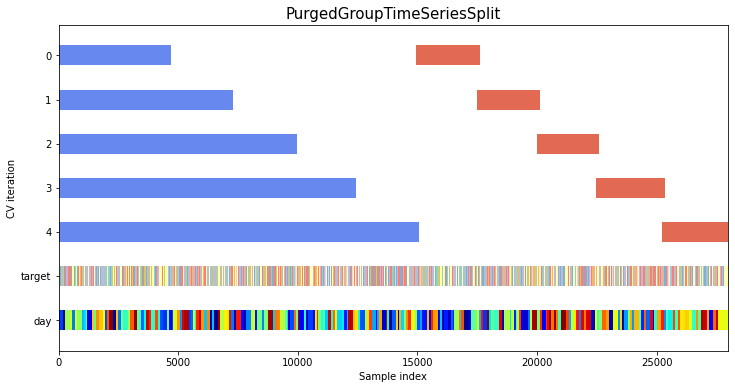

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))

cv = PurgedGroupTimeSeriesSplit(
    n_splits=FOLDS,
    max_train_group_size=MAX_TRAIN_GROUP_SIZE,
    group_gap=GROUP_GAP,
    max_test_group_size=MAX_TEST_GROUP_SIZE
)

plot_cv_indices(cv, x, y, groups, ax, FOLDS, lw=20);

In [ ]:
models = []

In [ ]:
from sklearn.ensemble import RandomForestRegressor


In [ ]:
for fold, (train_idx, val_idx) in enumerate(PurgedGroupTimeSeriesSplit(n_splits = FOLDS, group_gap = GROUP_GAP, max_train_group_size = MAX_TRAIN_GROUP_SIZE, max_test_group_size = MAX_TEST_GROUP_SIZE).split(x, y, groups)):

  x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
  y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

  print('#'*25); print('#### FOLD',fold+1)    
  print(f'Training with {len(x_train)} and validating on {len(x_val)}')

  model = lgb.LGBMRegressor(**params,  num_leaves=81, n_estimators=800)

  model.fit(x_train, y_train, 
          eval_set=[(x_train, y_train), (x_val, y_val)],
          verbose=20, early_stopping_rounds=200)
  
  models.append(model)

  pred = model.predict(x_val)
  r2_test = max(0,100*r2_score(y_val, pred))

  pred = model.predict(x_train)
  r2_train = max(0,100*r2_score(y_train, pred))


  print("\n********************")
  print(f"R^2 score is {r2_train, r2_test}")
  print("********************\n")


#########################
#### FOLD 1
Training with 4568 and validating on 2442
Training until validation scores don't improve for 200 rounds.
[20]	training's l1: 0.831206	valid_1's l1: 0.892997
[40]	training's l1: 0.387579	valid_1's l1: 0.4901
[60]	training's l1: 0.254282	valid_1's l1: 0.393848
[80]	training's l1: 0.204772	valid_1's l1: 0.370529
[100]	training's l1: 0.176394	valid_1's l1: 0.36431
[120]	training's l1: 0.154608	valid_1's l1: 0.364193
[140]	training's l1: 0.136101	valid_1's l1: 0.364241
[160]	training's l1: 0.120333	valid_1's l1: 0.364422
[180]	training's l1: 0.106798	valid_1's l1: 0.364735
[200]	training's l1: 0.0955859	valid_1's l1: 0.365689
[220]	training's l1: 0.0854115	valid_1's l1: 0.365972
[240]	training's l1: 0.0768732	valid_1's l1: 0.366263
[260]	training's l1: 0.0691845	valid_1's l1: 0.366843
[280]	training's l1: 0.0624712	valid_1's l1: 0.367414
[300]	training's l1: 0.0564838	valid_1's l1: 0.367616
Early stopping, best iteration is:
[109]	training's l1: 0.16623

In [ ]:
models

[LGBMRegressor(metric='l1', n_estimators=800, objective='regression'),
 LGBMRegressor(metric='l1', n_estimators=800, objective='regression'),
 LGBMRegressor(metric='l1', n_estimators=800, objective='regression'),
 LGBMRegressor(metric='l1', n_estimators=800, objective='regression'),
 LGBMRegressor(metric='l1', n_estimators=800, objective='regression')]

In [ ]:
prediction = 0
for model in models:
  prediction += model.predict(X_test)

r2 = max(0,100*r2_score(y_test, prediction/5))

print("\n********************")
print(f"R^2 score is {r2}")
print("********************\n")


********************
R^2 score is 98.52874106048156
********************



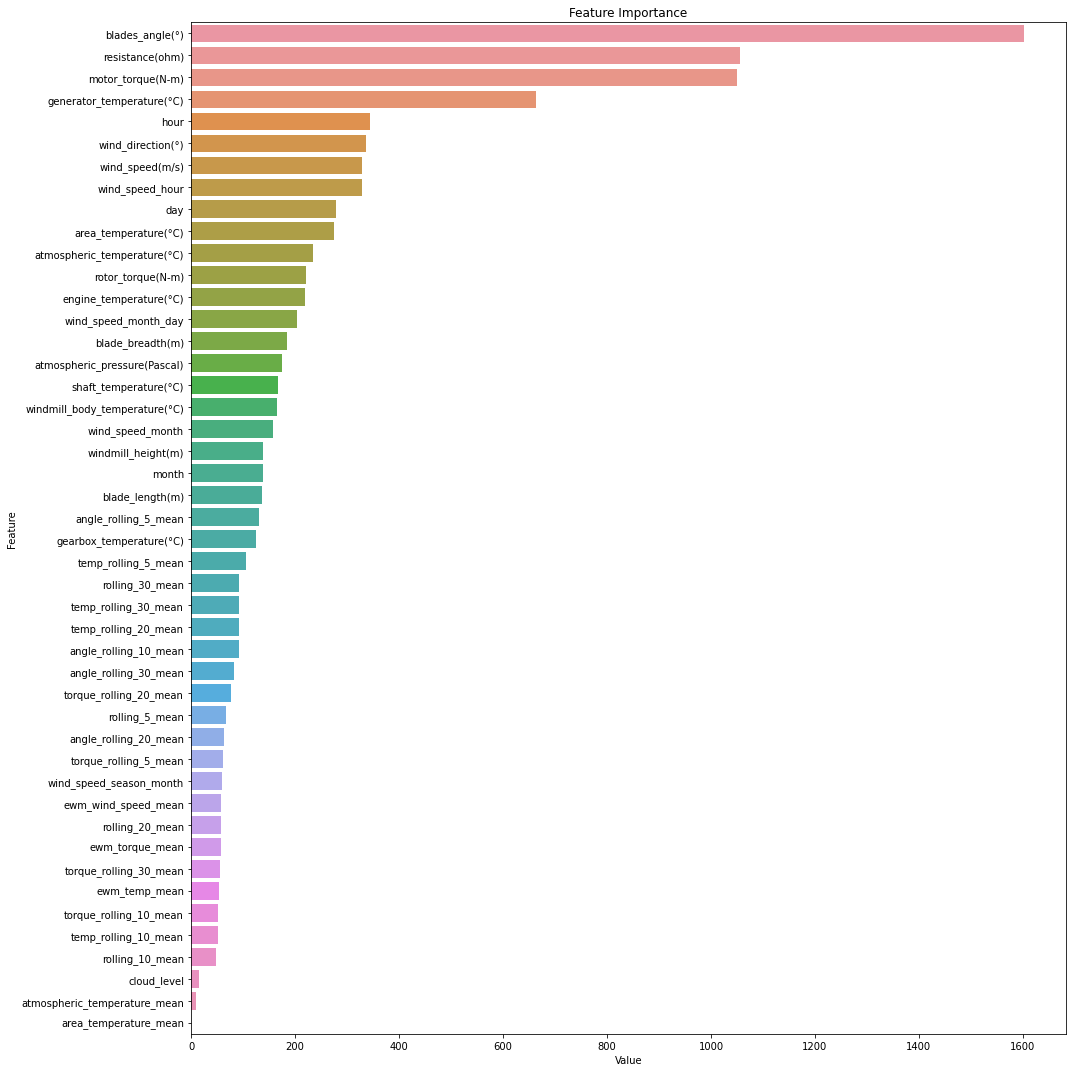

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(models[3].feature_importances_, x_train.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
    
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=20, early_stopping_rounds=50)

pred = model.predict(X_test)
r2 = max(0,100*r2_score(y_test, pred))

print("\n********************")
print(f"R^2 score is {r2}")

Training until validation scores don't improve for 50 rounds.
[20]	training's l1: 0.473673	valid_1's l1: 0.484596
[40]	training's l1: 0.336119	valid_1's l1: 0.357041
[60]	training's l1: 0.313809	valid_1's l1: 0.340571
[80]	training's l1: 0.301195	valid_1's l1: 0.334494
[100]	training's l1: 0.292388	valid_1's l1: 0.333911
[120]	training's l1: 0.284173	valid_1's l1: 0.332001
[140]	training's l1: 0.276354	valid_1's l1: 0.330128
[160]	training's l1: 0.269611	valid_1's l1: 0.328608
[180]	training's l1: 0.263086	valid_1's l1: 0.327511
[200]	training's l1: 0.256838	valid_1's l1: 0.326325
[220]	training's l1: 0.250836	valid_1's l1: 0.325409
[240]	training's l1: 0.243425	valid_1's l1: 0.322949
[260]	training's l1: 0.238197	valid_1's l1: 0.321958
[280]	training's l1: 0.233012	valid_1's l1: 0.321222
[300]	training's l1: 0.227937	valid_1's l1: 0.320721
[320]	training's l1: 0.222588	valid_1's l1: 0.31958
[340]	training's l1: 0.21844	valid_1's l1: 0.319768
[360]	training's l1: 0.214342	valid_1's l1:

In [ ]:
#DecisionTree
from sklearn import tree
from sklearn.metrics import r2_score

Dt = tree.DecisionTreeRegressor()
Dt = Dt.fit(X_train.values, y_train.values)

y_pred = Dt.predict([X_test.iloc[i] for i in range(len(X_test))])
r2_score(y_test, y_pred)

0.9125534944913011

In [ ]:
#GBA
from sklearn.ensemble import GradientBoostingRegressor

gba = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=0).fit(X_train.values, y_train.values)

y_pred = gba.predict([X_test.iloc[i] for i in range(len(X_test))])
r2_score(y_test, y_pred)

0.9552004170051565

In [ ]:
#Polynomial
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

poly = make_pipeline(PolynomialFeatures(degree=2), LinearRegression(fit_intercept = False))
poly.fit(X_train.values,y_train.values)

y_pred = poly.predict([X_test.iloc[i] for i in range(len(X_test))])
r2_score(y_test, y_pred)

0.7945657037352558

In [ ]:
y_pred = Dt.predict([X_train.iloc[i] for i in range(len(X_train))])
r2_score(y_train, y_pred)

1.0

In [ ]:
print(len(X_train.columns))

32


In [ ]:
print(X_train.shape)

(7015, 32)


In [ ]:
#CNN
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

model = Sequential()
model.add(Conv1D(32, 16, activation="relu", input_shape=(32, 1)))
model.add(Conv1D(16, 2, activation="relu", input_shape=(32, 16)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")
 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 17, 32)            544       
                                                                 
 conv1d_3 (Conv1D)           (None, 16, 16)            1040      
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,097
Trainable params: 18,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train.values, y_train.values, batch_size=12,epochs=100, verbose=1)

Epoch 1/100
585/585 [==============================] - 2s 2ms/step - loss: 877028.5000
Epoch 2/100
585/585 [==============================] - 1s 2ms/step - loss: 301.5375
Epoch 3/100
585/585 [==============================] - 1s 2ms/step - loss: 11256.2285
Epoch 4/100
585/585 [==============================] - 1s 2ms/step - loss: 155436.6562
Epoch 5/100
585/585 [==============================] - 1s 2ms/step - loss: 12638.0146
Epoch 6/100
585/585 [==============================] - 1s 2ms/step - loss: 1124.3367
Epoch 7/100
585/585 [==============================] - 1s 2ms/step - loss: 17.9074
Epoch 8/100
585/585 [==============================] - 1s 2ms/step - loss: 91.5484
Epoch 9/100
585/585 [==============================] - 1s 2ms/step - loss: 378.0317
Epoch 10/100
585/585 [==============================] - 1s 2ms/step - loss: 8895.9336
Epoch 11/100
585/585 [==============================] - 1s 2ms/step - loss: 472.8375
Epoch 12/100
585/585 [==============================] - 1s 2ms/s

In [ ]:
print(model.evaluate(X_train.values, y_train.values))

220/220 [==============================] - 0s 1ms/step - loss: 4.4976
4.497591018676758


In [ ]:
print(X_train.iloc[1].shape)

(32,)


In [ ]:
y_pred = model.predict(X_test.values)
# y_pred = model.predict([X_test.iloc[i] for i in range(len(X_test))])
r2_score(y_test, y_pred)

0.3133504126448057